In [2]:
import numpy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score

from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import GlobalAlignmentKernelKMeans
from tslearn.metrics import sigma_gak, cdist_gak

import sys
import numpy as np
import yaml
from typing import Dict
from tqdm import tqdm

from adase.utils.pandas import read_df
from adase.utils.files import (directory_path,
                                get_raw_file,
                                get_all_files)
from adase.utils.pandas import write_df, read_df

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")

In [3]:
def config(path) -> Dict:
    with open("{}config.yml".format(path), 'r') as ymlfile:
            cfg = yaml.load(ymlfile)
    return cfg

def download_dataset(cfg:Dict):
    
    raw_path = cfg.get('dataset').get('path_read_input')
    for file in tqdm(cfg.get('makedataset').get('files')):
        get_raw_file(raw_path, file)

def load_dataset(cfg:Dict):
    
    raw_path = cfg.get('dataset').get('path_read_input')
    
    dict_data: Dict = dict()

    for key, val in read_df(get_all_files(raw_path)).items():

        df_tmp = val.rename(columns={
                    'item': 'item_code',
                    'quantity_ecd': 'quantity',
                    'parent_item': 'parent_item_code',
                    'parent_quantity_ecd': 'parent_quantity'
                })

        if 'rpd' in df_tmp:
            first_element = sorted(df_tmp['rpd'].unique())[0]
            if first_element/1 != 1:
                df_tmp['rpd'] = df_tmp['rpd'] - (first_element-1)

        dict_data.update({key: df_tmp})
                
    return dict_data

cfg = config('../')
download_dataset(cfg)
data_dicts = load_dataset(cfg)

100%|██████████| 9/9 [00:00<00:00, 124.16it/s]


In [4]:
data_series = data_dicts.get('demand_out_encoded_stage_3')\
.set_index(['item_code', 'rpd','future_flag'])\
.sort_index().unstack("rpd", fill_value=0).fillna(0).values

mu, sigma = 0, 0.1 
#[:600]
#data = np.log1p(
data = np.log1p(data_series[:]) + np.abs(np.random.normal(mu, sigma, size=data_series.shape))

In [5]:
def plot_data(ks, X_train, y_pred, sz, n_clusters=3, centroid=False):
    
    plt.figure(figsize=(12,25))
    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, 1 + yi)
        for xx in X_train[y_pred == yi]:
            #, alpha=.2
            plt.plot(xx.ravel(), "k-")
            #,
        if centroid:
            plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        #plt.ylim(-4, 4)
        plt.title("Cluster %d" % (yi + 1))

    plt.tight_layout()
    plt.show()
    
def split_train_test(X, y, size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=size)
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    
def normalize_data(data):
    numpy.random.shuffle(data)
    X_train = TimeSeriesScalerMeanVariance().fit_transform(data_series)
    sz = X_train.shape[1]
    
    return X_train, sz

def k_shape(data_series_normalized, n_clusters=3, verbose=True, seed=0):

    # Euclidean k-means
    ks = KShape(n_clusters=n_clusters, verbose=verbose, random_state=seed)
    
    return ks, ks.fit_predict(X_train)

def compute_scores(ks, X_train, y_pred, centroid=False):

    scores = []
    for yi in range(ks.n_clusters):
        tp_list = []
        for xx in X_train[y_pred == yi]:
            
            if centroid:
                predicted = ks.cluster_centers_[yi].ravel()
                actual = xx.ravel()
                score = adjusted_rand_score(actual, predicted)
                scores.append(score)
                
            else:
                predicted = xx.ravel()
                tp_list.append(predicted)
        
        if not centroid:
            half = len(tp_list)//2
            first_half = tp_list[:half]
            second_half = tp_list[half:]
            
            for i in np.arange(half):
                score = adjusted_rand_score(first_half[i], second_half[i])
                scores.append(score)
                            
            
    return scores
    #print('score: {0} -- actual: {1} -- predicted: {2}'.format(score, actual, predicted))

In [6]:
X_train, sz = normalize_data(data_series[:500])

In [ ]:
ks, y_pred = k_shape(X_train, n_clusters=20)
scores = compute_scores(ks, X_train, y_pred)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f29472c14a8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f29472c1ba8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f29472c1320>],
 'medians': [<matplotlib.lines.Line2D at 0x7f29472df2e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f29472df668>],
 'means': []}

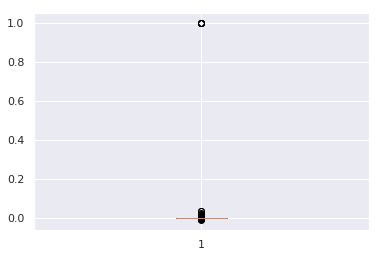

In [120]:
plt.boxplot(scores)

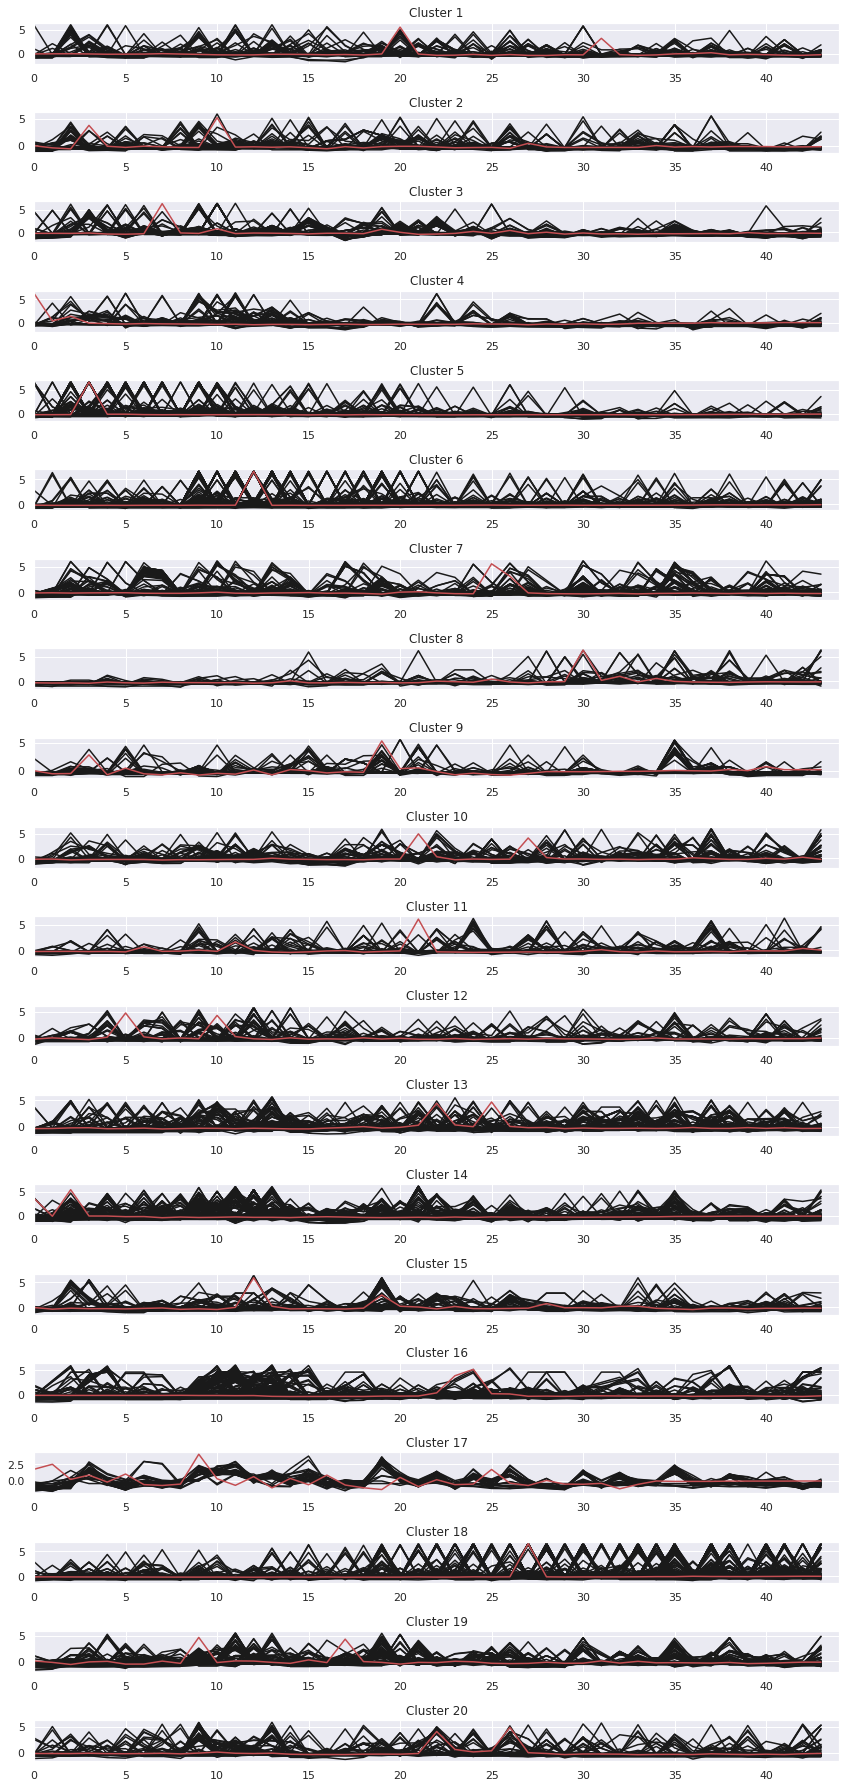

In [121]:
plot_data(ks, X_train, y_pred, sz, ks.n_clusters)

In [189]:
sz = X_train.shape[1]
gak_km = GlobalAlignmentKernelKMeans(n_clusters=20, 
                                     sigma=sigma_gak(X_train), 
                                     n_init=20, verbose=False, 
                                     random_state=seed)
y_pred = gak_km.fit_predict(X_train)



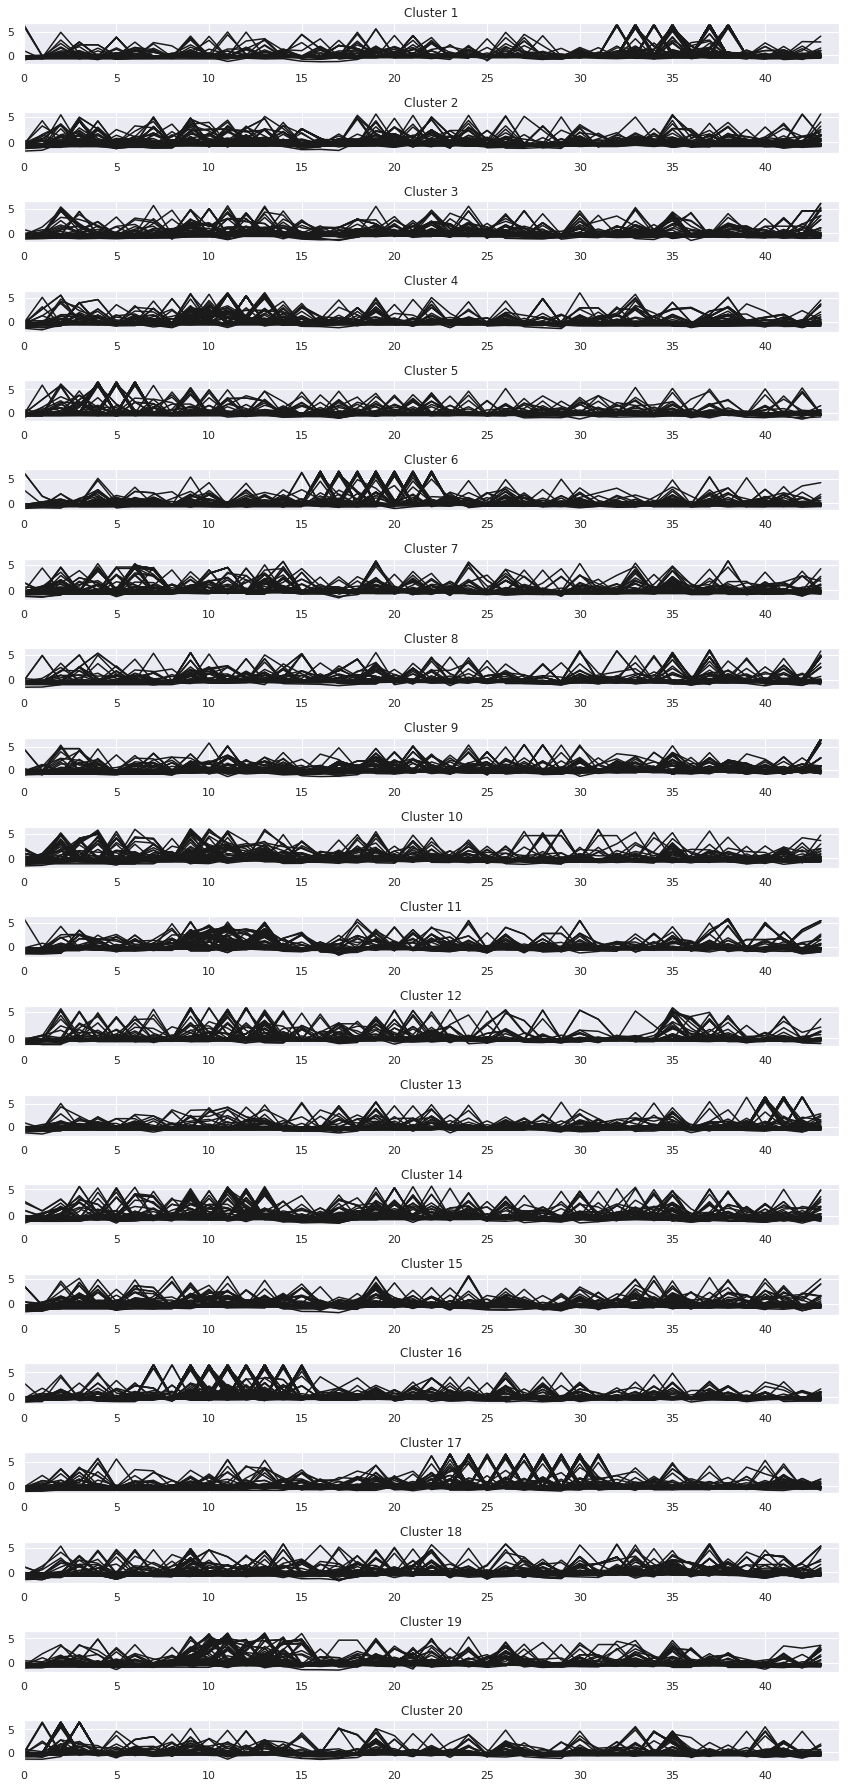

In [190]:
plot_data(gak_km, X_train, y_pred, sz, gak_km.n_clusters)

In [191]:
scores_km_shifted = compute_scores(gak_km, X_train, y_pred, centroid=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2943c76d30>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2943c7e470>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2943c76ba8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2943c7eb70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2943c7eef0>],
 'means': []}

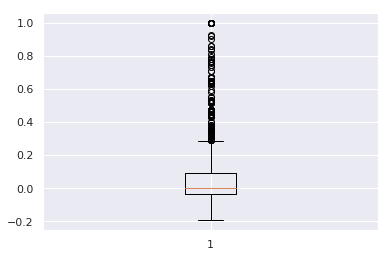

In [192]:
plt.boxplot(scores_km_shifted)

In [200]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=20, metric="softdtw", metric_params={"gamma_sdtw": .01},
                           verbose=True, random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

Soft-DTW k-means
73.771 --> 44.204 --> 40.765 --> 37.774 --> 34.382 --> 32.672 --> 32.355 --> 32.080 --> 31.764 --> 31.497 --> 31.390 --> 31.137 --> 30.921 --> 30.592 --> 30.411 --> 30.186 --> 29.934 --> 29.449 --> 28.472 --> 26.719 --> 26.233 --> 26.235 --> 26.231 --> 26.220 --> 26.202 --> 26.193 --> 26.192 --> 26.187 --> 26.179 --> 26.174 --> 26.170 --> 26.159 --> 26.156 --> 26.152 --> 26.148 --> 26.145 --> 26.143 --> 26.142 --> 26.140 --> 26.139 --> 26.136 --> 26.135 --> 26.135 --> 26.134 --> 26.134 --> 26.133 --> 26.133 --> 26.132 --> 26.132 --> 26.132 --> 


In [203]:
scores_kmeans_softdtw = compute_scores(sdtw_km, X_train, y_pred, centroid=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2946ebc7f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2946ebcef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2946ebc668>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2947dd2630>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2947dd29b0>],
 'means': []}

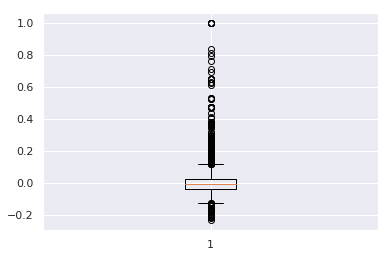

In [204]:
plt.boxplot(scores)

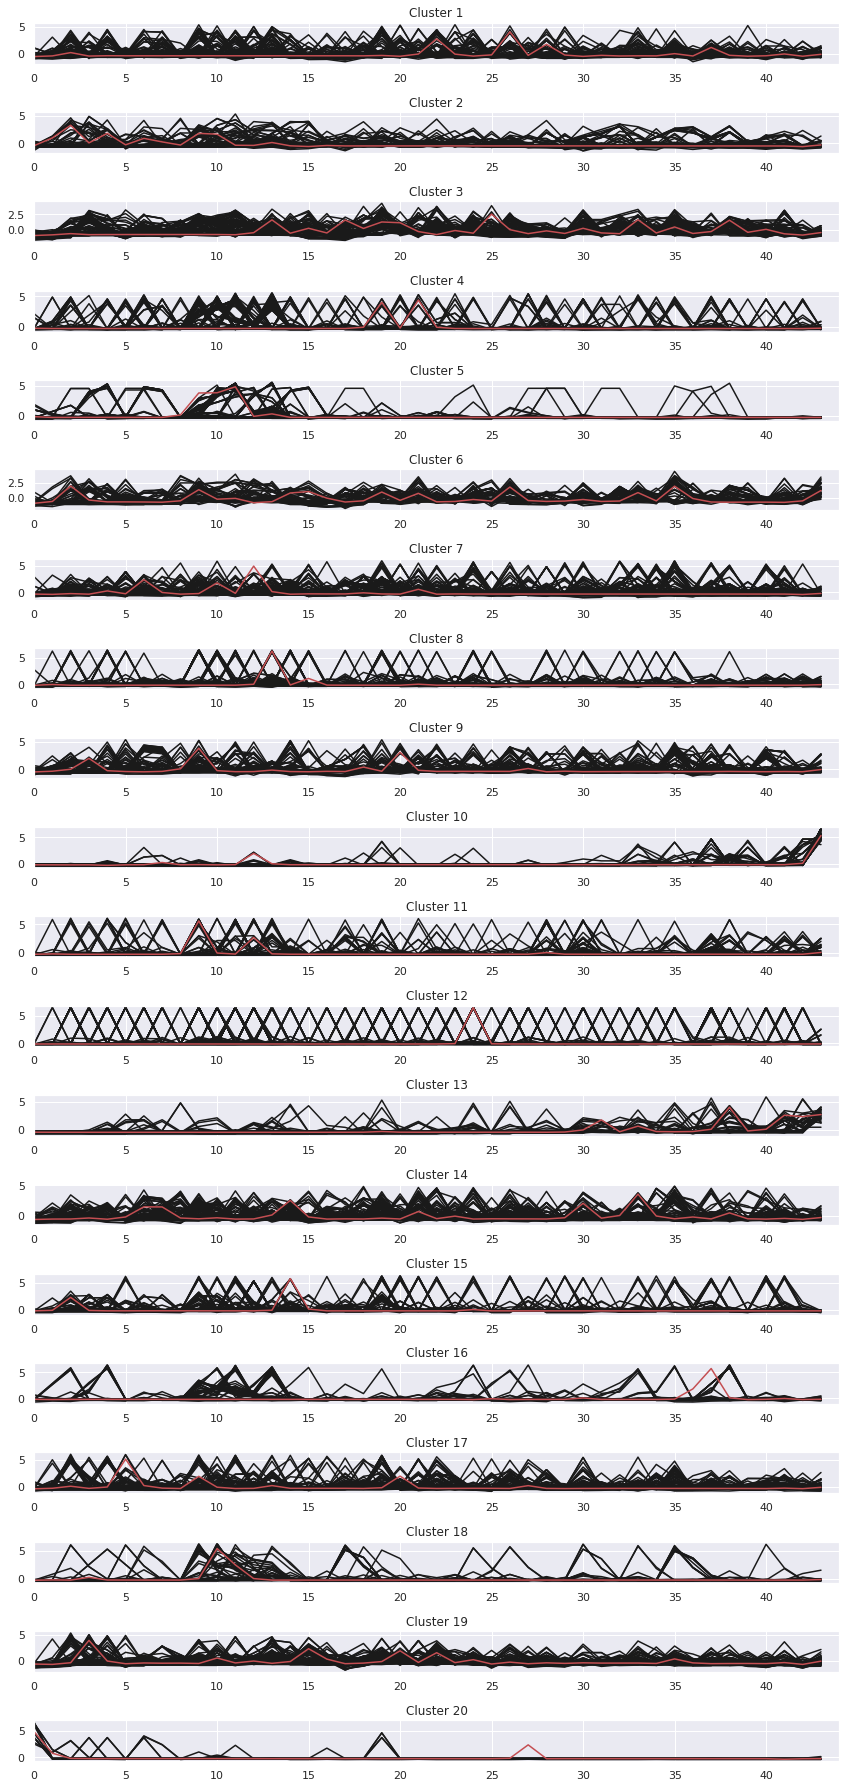

In [206]:
plot_data(sdtw_km, X_train, y_pred, sz, sdtw_km.n_clusters, centroid=True)

In [7]:
from tslearn import metrics


dataset_scaled = X_train.reshape((2646, 44))
envelope_down, envelope_up = metrics.lb_envelope(dataset_scaled[1], radius=3)

distances_dict = list()

for i in np.arange(len(X_train)):
    distance = metrics.lb_keogh(dataset_scaled[i], envelope_candidate=(envelope_down, envelope_up))
    distances_dict.append((i,distance))

In [8]:
import pandas as pd

distances_df = pd.DataFrame(distances_dict, columns=['series', 'value'])

In [10]:
import numpy as np
from sklearn import mixture

x = np.array(distances_df['value'])
clf = mixture.GaussianMixture(n_components=20, covariance_type='full')
clf.fit(x.reshape(-1,1))

labels = clf.predict(x.reshape(-1,1))
y = np.array(distances_df['series'])


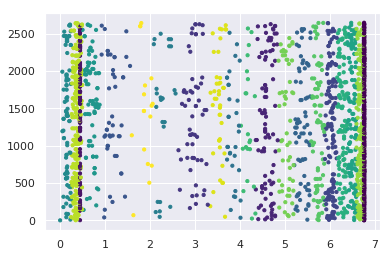

In [23]:
plt.scatter(x, y, c=labels, s=10, cmap='viridis');

In [270]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

In [271]:
X

array([[ 6.48826703e+00,  2.50064460e-01],
       [ 2.52194722e+00, -2.69798647e+00],
       [ 3.06877291e+00, -2.90007604e+00],
       [ 4.31427482e+00,  7.02950576e-01],
       [ 2.38449945e+00, -2.53563494e+00],
       [ 7.80540956e+00, -1.70297829e+00],
       [ 8.38773426e-01,  2.22322228e+00],
       [ 4.17614316e+00,  7.93137001e-03],
       [ 3.02668532e+00, -1.79041773e+00],
       [ 1.26987864e+00,  1.76747403e+00],
       [ 7.81974467e+00, -9.49424332e-01],
       [ 1.87335276e-01,  2.51921931e+00],
       [ 3.43116792e+00,  2.33812285e+00],
       [ 3.39806103e+00, -2.39482483e+00],
       [ 2.95679593e+00, -7.91981675e-01],
       [ 1.13171965e+00,  3.22881491e+00],
       [ 1.59701749e+00, -1.80822253e+00],
       [ 4.09867867e-01,  1.62350489e+00],
       [ 3.89290127e+00,  1.21767506e+00],
       [ 3.54666555e+00, -1.22768985e+00],
       [ 3.53554556e+00, -1.06406044e+00],
       [ 2.66329169e+00, -2.07216196e+00],
       [ 7.15134224e+00, -1.95483315e+00],
       [ 4.